# Import

In [138]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import category_encoders as ce
import sweetviz as sv
import statsmodels.formula.api as smf
import pingouin as pg

from IPython.core.display import display, HTML
import warnings

# Def Function

In [139]:
def side_by_side_tables(model1, model2):
    # Getting the summaries as HTML
    resume_model1_html = model1.summary().as_html()
    resume_model2_html = model2.summary().as_html()

    # Creating an HTML div that contains the tables side by side
    side_by_side_tables_html = f'<div style="display:flex;">' \
                               f'<div style="margin-right:20px;">{resume_model1_html}</div>' \
                               f'<div>{resume_model2_html}</div>' \
                               f'</div>'

    # Displaying tables side by side
    display(HTML(side_by_side_tables_html))

def rename_columns(df):
    # Convert column names to lowercase
    df.columns = [col.lower() for col in df.columns]

    # Rename specific columns
    df = df.rename(columns={
        'naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_1':
        'naive_bayes_classifier_1',
        'naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_2':
        'naive_bayes_classifier_2'
    })

    return df

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [12, 6]
    plt.rcParams['font.size'] = 16
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [140]:
jupyter_settings();

Populating the interactive namespace from numpy and matplotlib


In [141]:
sns.set(style='whitegrid')

In [142]:
warnings.filterwarnings("ignore")

# Data Preprocessing

In [232]:
df = pd.read_csv('Data/BankChurners.csv')
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [233]:
df.shape

(10127, 23)

In [234]:
df.dtypes

CLIENTNUM                                                                                                                               int64
Attrition_Flag                                                                                                                         object
Customer_Age                                                                                                                            int64
Gender                                                                                                                                 object
Dependent_count                                                                                                                         int64
Education_Level                                                                                                                        object
Marital_Status                                                                                                                         object
Income

In [235]:
df.isna().sum()

CLIENTNUM                                                                                                                             0
Attrition_Flag                                                                                                                        0
Customer_Age                                                                                                                          0
Gender                                                                                                                                0
Dependent_count                                                                                                                       0
Education_Level                                                                                                                       0
Marital_Status                                                                                                                        0
Income_Category                                 

In [236]:
df = rename_columns(df)

In [237]:
existing_customer = re.compile('Existing Customer')	
attrited_customer = re.compile('Attrited Customer')

df['attrition_flag'] = df['attrition_flag'].apply(lambda x: existing_customer.sub('1', x))
df['attrition_flag'] = df['attrition_flag'].apply(lambda x: attrited_customer.sub('0', x))

df['attrition_flag'] = pd.to_numeric(df['attrition_flag'], errors='coerce')

In [238]:
df.head()

,clientnum,attrition_flag,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio,naive_bayes_classifier_1,naive_bayes_classifier_2
0,768805383,1,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,1,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,1,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,1,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,1,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [239]:
df.dtypes

clientnum                     int64
attrition_flag                int64
customer_age                  int64
gender                       object
dependent_count               int64
education_level              object
marital_status               object
income_category              object
card_category                object
months_on_book                int64
total_relationship_count      int64
months_inactive_12_mon        int64
contacts_count_12_mon         int64
credit_limit                float64
total_revolving_bal           int64
avg_open_to_buy             float64
total_amt_chng_q4_q1        float64
total_trans_amt               int64
total_trans_ct                int64
total_ct_chng_q4_q1         float64
avg_utilization_ratio       float64
naive_bayes_classifier_1    float64
naive_bayes_classifier_2    float64
dtype: object

## Categorial variables analysis

df.dependent_count.value_counts()

In [240]:
df.card_category.value_counts()

Blue        9436
Silver       555
Gold         116
Platinum      20
Name: card_category, dtype: int64

In [241]:
df.education_level.value_counts()

Graduate         3128
High School      2013
Unknown          1519
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: education_level, dtype: int64

In [242]:
df.marital_status.value_counts()

Married     4687
Single      3943
Unknown      749
Divorced     748
Name: marital_status, dtype: int64

In [243]:
df.income_category.value_counts()

Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
Unknown           1112
$120K +            727
Name: income_category, dtype: int64

- As there is no possibility of a client being outside one of these categories, we will consider unknowns as NaN

In [244]:
# unknown = re.compile('Unknown')
# df['income_category'] = df['income_category'].apply(lambda x: unknown.sub('NaN', x))

# Feature Engineering

# EDA

In [154]:
#sv.analyze(df).show_html()

In [155]:
df.describe()

,clientnum,attrition_flag,customer_age,dependent_count,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio,naive_bayes_classifier_1,naive_bayes_classifier_2
count,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,7.391776e+08,0.839340,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894,0.159997,0.840003
std,3.690378e+07,0.367235,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691,0.365301,0.365301
min,7.080821e+08,0.000000,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000,0.000008,0.000420
25%,7.130368e+08,1.000000,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000,0.000099,0.999660
50%,7.179264e+08,1.000000,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000,0.000181,0.999820
75%,7.731435e+08,1.000000,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000,0.000337,0.999900
max,8.283431e+08,1.000000,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000,0.999580,0.999990


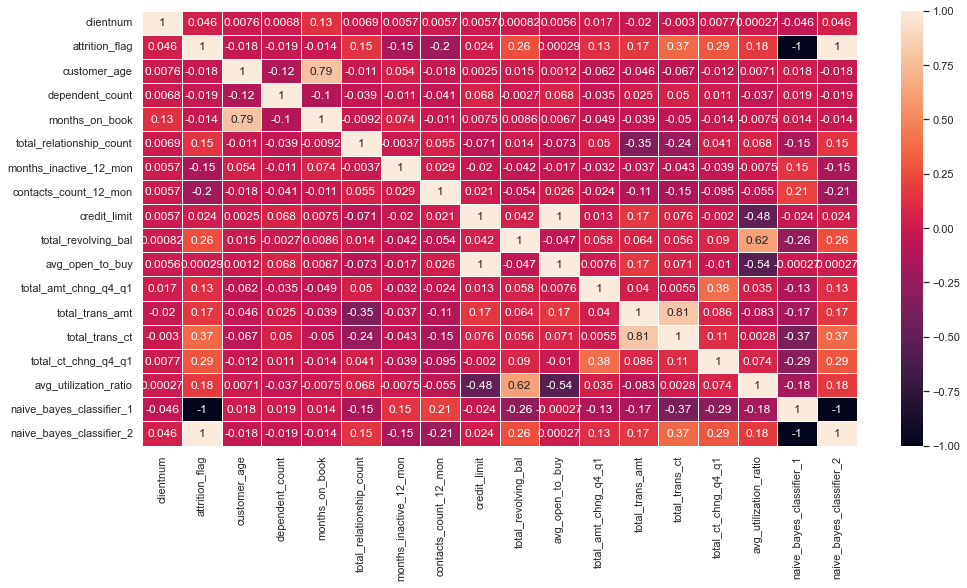

In [206]:
plt.figure(figsize=(16,8))
sns.heatmap(df.corr(method='pearson'), annot=True, linewidths=.5);

In [157]:
pg.ttest(df.total_trans_amt, df.total_trans_ct)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,128.537663,20252,two-sided,0.0,"[4273.06, 4405.4]",1.806363,inf,1.0


In [158]:
pg.ttest(df.months_on_book, df.customer_age)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-92.465139,20252,two-sided,0.0,"[-10.62, -10.18]",1.299429,inf,1.0


- By analyzing the heat map, we noticed that the features "naive_bayes_classifier_1" and "naive_bayes_classifier_2" have a high inverse correlation, in addition, "avg_open_to_buy" and "credit_limit" also have a high level of correlation. We also analyzed the relationship between the features "total_trans_amt" and "total_trans_ct" which present a statistically significant difference by the T test as well as "months_on_book" and "customer_age".

In [160]:
aux1 = df.groupby(['income_category','attrition_flag']).agg({'credit_limit' : 'mean'})
aux1.reset_index(inplace=True)
aux1

,income_category,attrition_flag,credit_limit
0,$120K +,0,19734.380952
1,$120K +,1,19713.746256
2,$40K - $60K,0,5049.799262
3,$40K - $60K,1,5535.845622
4,$60K - $80K,0,10491.971958
5,$60K - $80K,1,10800.343776
6,$80K - $120K,0,15296.733058
7,$80K - $120K,1,15905.934416
8,Less than $40K,0,3483.306536
9,Less than $40K,1,3810.664937


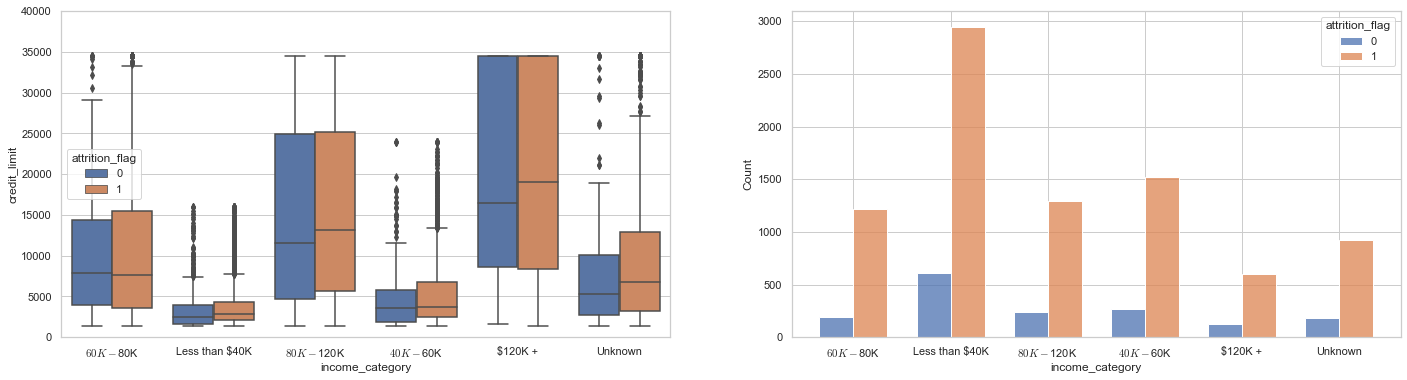

In [198]:
plt.figure(figsize=(24,6))

plt.subplot(1, 2, 1)
sns.boxplot(x='income_category', y='credit_limit', data=df, hue=df.attrition_flag)
plt.ylim(0,40000)

plt.subplot(1, 2, 2)
sns.histplot(x='income_category', hue='attrition_flag', data=df, multiple='dodge', shrink=0.7);

plt.show()

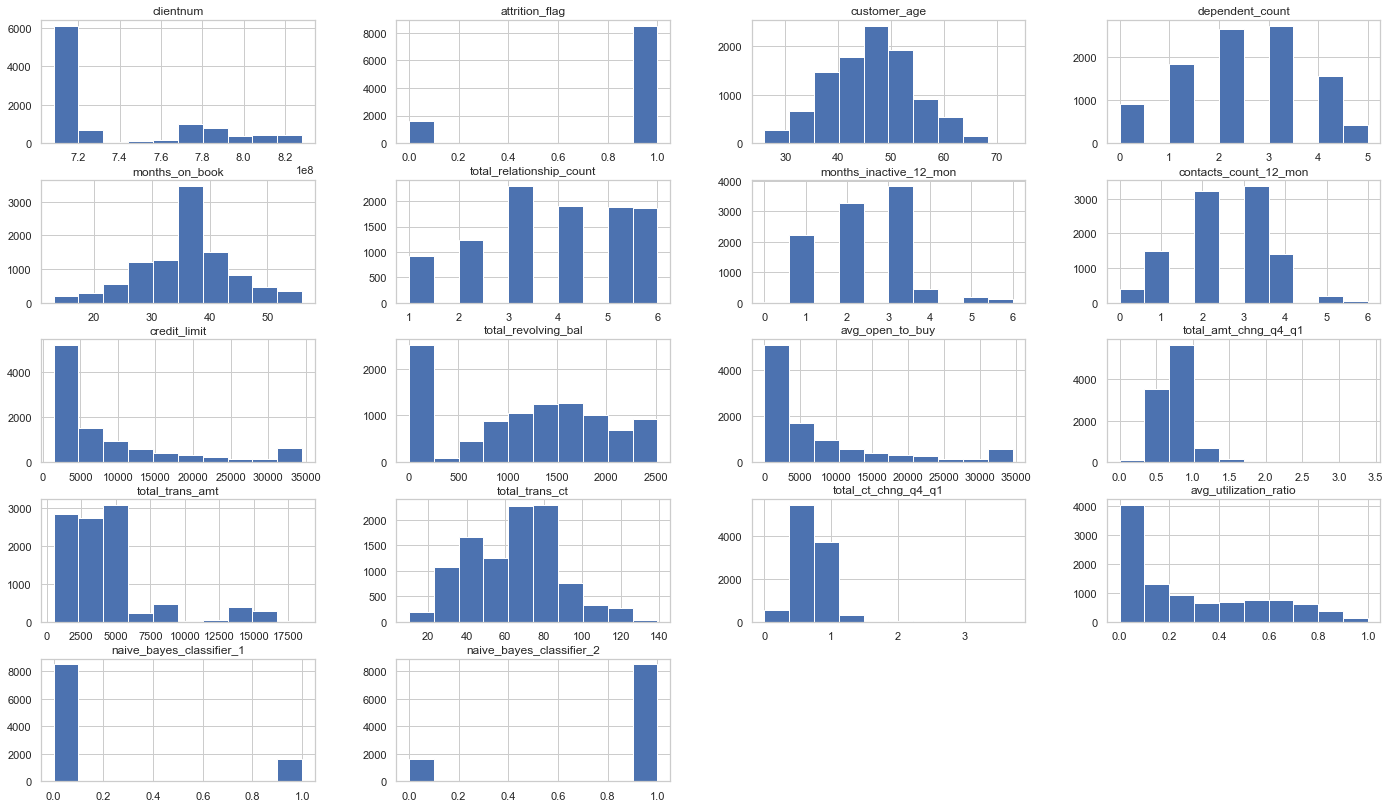

In [161]:
features = df.columns.tolist()
df[features].hist(figsize=(24, 14));

In [162]:
aux2 = df.groupby('customer_age').agg({'credit_limit' : 'mean'})
aux2.reset_index(inplace=True)
aux2.head(10)

,customer_age,credit_limit
0,26,4591.953846
1,27,5532.996875
2,28,8910.103448
3,29,7457.260714
4,30,6466.075714
5,31,8477.200000
6,32,8170.900943
7,33,7455.800000
8,34,7364.219863
9,35,7132.426630


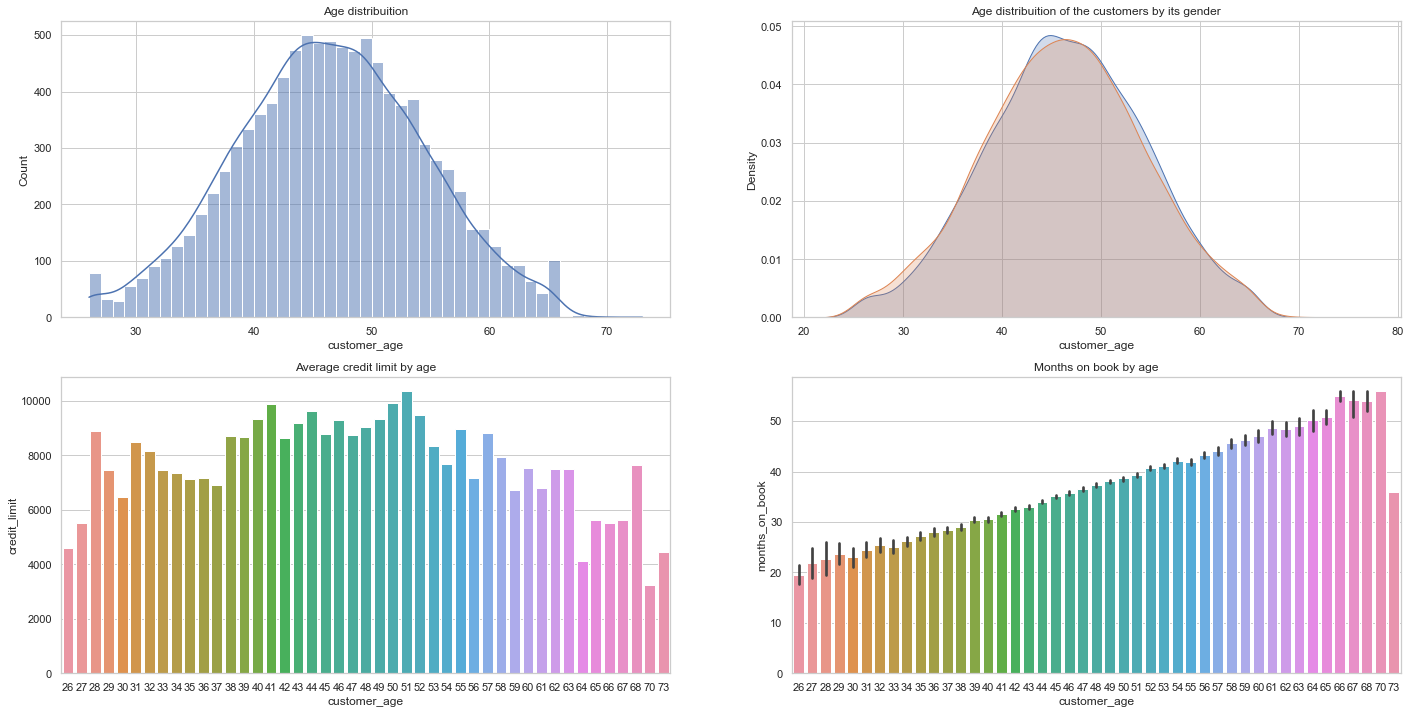

In [201]:
plt.figure(figsize=(24,12))

plt.subplot(2, 2, 1)
sns.histplot(df.customer_age, kde=True)
plt.title('Age distribuition')

plt.subplot(2, 2, 2)
sns.kdeplot(df[df['gender'] == 'F']['customer_age'], label='F', shade=True)
sns.kdeplot(df[df['gender'] == 'M']['customer_age'], label='M', shade=True)
plt.title('Age distribuition of the customers by its gender')

plt.subplot(2, 2, 3)
sns.barplot(x='customer_age', y='credit_limit', data=aux2)
plt.title('Average credit limit by age')

plt.subplot(2, 2, 4)
sns.barplot(x='customer_age', y='months_on_book', data=df)
plt.title('Months on book by age')

plt.show()

In [ ]:
model1 = smf.ols(formula='credit_limit ~ customer_age', data=aux2).fit()
model2 = smf.ols(formula='credit_limit ~ customer_age + I(customer_age**2)', data=aux2).fit()

side_by_side_tables(model1, model2)

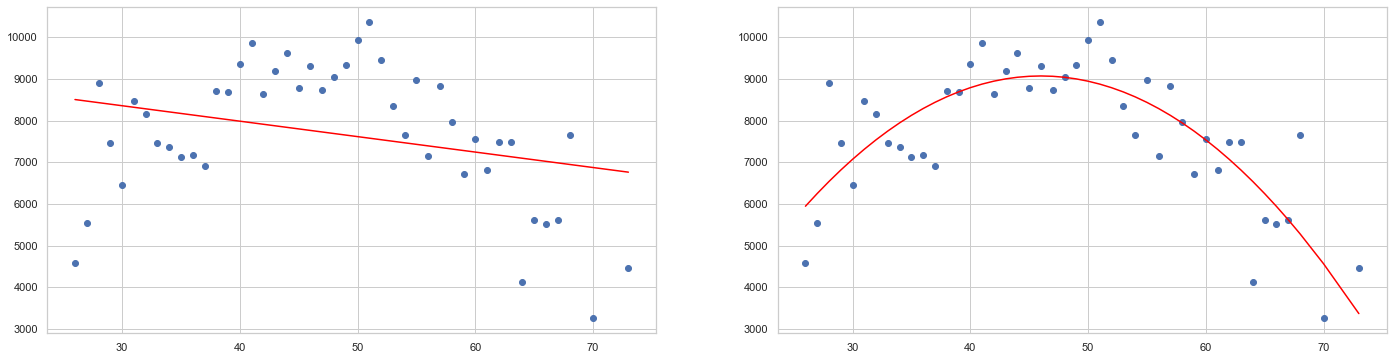

In [165]:
yhat1 = model1.predict(aux2.customer_age)
yhat2 = model2.predict(aux2.customer_age)
plt.figure(figsize=(24,6))

plt.subplot(1, 2, 1)
plt.scatter(x='customer_age', y='credit_limit', data=aux2)
plt.plot(aux2.customer_age, yhat1, c='red')

plt.subplot(1, 2, 2)
plt.scatter(x='customer_age', y='credit_limit', data=aux2)
plt.plot(aux2.customer_age, yhat2, c='red');

In [167]:
pg.ttest(
    df.loc[df.gender == 'M', 'customer_age'],
    df.loc[df.gender == 'F', 'customer_age']
)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.740356,9944.619099,two-sided,0.081827,"[-0.59, 0.04]",0.034684,0.102,0.413849


# Model

# Metrics Comprehension